In [7]:
import numpy as np
import matplotlib.pyplot as plt
from OCP_algorithms import hospital_capacity_objective_solve, quadratic_objective_solve, week_objective_solve

from SIR_Plotting_Routines import *
import pysindy as ps
import glob
import pandas as pd


from os.path import basename
import os
import sys


cwd = os.path.dirname(os.path.abspath(''))
# sys.path.append(cwd + '/Cpp/build/Binders/')
import pyFROLS as pf

DATA_DIR = cwd + '/Cpp/data/'
FIGURE_DIR = cwd + '/../../figures/'

In [8]:
d_max = 1
N_output_max = 80
Nx = 3
Nu = 1
Nt = 50
er_model = pf.Polynomial_Model(Nx,Nu,N_output_max,d_max)
# er_features = er_model.read_csv(DATA_DIR + 'ERR_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/param.csv')


In [9]:
qr_model = pf.Polynomial_Model(Nx,Nu,N_output_max,d_max)
# qr_features = qr_model.read_csv(DATA_DIR + 'Quantile_Simulation_SIR_' + str(N_pop) + '_' + str(p_ER) + '/param.csv')

In [10]:
from pysindy_casadi_converter import construct_mx_equations
import casadi as cs


In [11]:
import random
N_sims = 100
p_I0 = 0.1
# #generate integer seeds
# qr_seeds = [random.randint(0, 1000000) for i in range(N_sims)]

# er_sims = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, p_I0, er_seeds, Nt, 100)
# qr_sims = pf.Bernoulli_SIR_MC_Simulations(N_pop, p_ER, p_I0, qr_seeds, Nt, 100)
# er_X_list = [np.array([x[0], x[1], x[2]]) for x in er_sims]
# qr_X_list = [np.array([x[0], x[1], x[2]]) for x in qr_sims]
graph_seed = 777
p_gen = pf.MC_SIR_Params()
p_gen.N_pop = 20
p_gen.p_I0 = 0.1
er_param = pf.Regressor_Param()
er_param.tol = 1e-4
er_regressor = pf.ERR_Regressor(er_param)
qr_param = pf.Quantile_Param()
qr_param.tol = 1e-4
qr_regressor = pf.Quantile_Regressor(qr_param)

er_seeds = [random.randint(0, 1000000) for i in range(N_sims)]
def openloop_solve(N_pop, p_ER, regressor, model, seed, N_sims, Nt, Wu):
    p_gen = pf.MC_SIR_Params()
    p_gen.N_pop = 100
    p_gen.p_ER = 1
    p_gen.p_I0 = 0.1
    p_gen.N_I_min = 0
    #set numpy random seed
    np.random.seed(seed)
    #generate integer seeds
    seeds = [random.randint(0, 1000000) for i in range(N_sims)]
    x = cs.MX.sym('x', 3)
    u = cs.MX.sym('u', 1)
    G_structure = pf.generate_SIR_ER_graph(N_pop, p_ER, seed)
    G = pf.generate_Bernoulli_SIR_Network(G_structure, p_I0, seed, 0)
    G_mpc = G
    #generate integer seeds
    seeds = [random.randint(0, 1000000) for i in range(N_sims)]
    rd = pf.MC_SIR_simulations_to_regression(G_structure, p_gen, seeds, Nt)
    X_mean = np.mean(np.reshape(rd.X, (N_sims, Nt, Nx)), axis=0)
    U_mean = np.mean(np.reshape(rd.U, (N_sims, Nt, Nu)), axis=0)
    features = regressor.transform_fit(rd, model)
    F_ODE = cs.Function("F_ODE", [x, u], [cs.vertcat(*construct_mx_equations(x, u, model, features))])
    sol, x_pred, u_sol = week_objective_solve(X_mean, U_mean, Wu, F_ODE, Nt, N_pop)

    mpc_sir_p = [pf.SIR_Param() for i in range(Nt)]
    for i in range(Nt):
        mpc_sir_p[i].p_R = 0.1
        mpc_sir_p[i].p_I = u_sol[i]
        mpc_sir_p[i].N_I_min = 0        

    seeds = [random.randint(0, 1000000) for i in range(N_sims)]
    mpc_rd = pf.MC_SIR_simulations_to_regression(G_structure, p_gen, mpc_sir_p, seeds, Nt)



    return x_pred, u_sol, rd, mpc_rd, features

def solve_plot(N_pop, p_ER, regressor, model, file_prefix='er_'):
    #generate integer seed
    seed = random.randint(0, 1000000)
    Wu = 500
    x_pred, u_sol, rd, mpc_rd, features = openloop_solve(N_pop, p_ER, er_regressor, er_model, seed, N_sims, Nt, Wu)
    #p_ER with one decimal
    # p_ER_str = str(p_ER).split('.')[0] + '_' + str(p_ER).split('.')[1]
    p_ER_str = str(p_ER)
    er_model.write_latex(features, DATA_DIR + "/latex/" + file_prefix + "param_" + str(N_pop) + "_" + p_ER_str + ".tex", ["S_t", "I_t", "R_t"], ["p_I"], ["S_{t+1}", "I_{t+1}", "R_{t+1}"],  False, "&")

    fig, ax = plt.subplots(4)
    t = np.array(range(Nt))
    t_1 = np.array(range(Nt+1))
    i = 2
    plot_sim_comparison_SIR(ax, rd, x_pred, u_sol, t, N_sims, hatch='///', alpha_multiplier=.5)
    X_sim = np.reshape(mpc_rd.X, (N_sims, Nt, Nx))
    _ = [percentile_plot(ax[j], t, X_sim[:,:,j], color='gray', hatch='', alpha_mul=1, label='Controlled') for j in range(Nx)]
    _ = [ax[j].plot(t_1, x_pred[j,:].T, color='k', linestyle='--', label='MPC Prediction') for j in range(Nx)]
    # _ = [ax[j].plot(t, X_sim[:, :, j].T, color='gray', label='True', alpha=.6) for j in range(Nx)]

    counts, bins = np.histogram(rd.U[::Nt])
    ax[3].bar(bins[:-1], counts, width=np.diff(bins), color='gray', alpha=.5, label='Controlled')
    # _ = [ax[-1].plot(t, rd.U[i*Nt:(i+1)*Nt], color='gray', alpha=.2) for i in range(N_sims)]
    ax[0].legend(loc=1, prop={'size': 6})
    ax[-1].grid()
    fig.savefig(DATA_DIR + '/latex/Figures/' + file_prefix + 'MPC_full_' + str(N_pop) + "_" + str(p_ER) + '.png', format='png', dpi=1000)

    fig, ax = plt.subplots(2)

    plot_sim_comparison_SIR(ax, rd, x_pred, u_sol, t, N_sims, hatch='///', alpha_multiplier=.3, plot_idx=[1])
    X_sim = np.reshape(mpc_rd.X, (N_sims, Nt, Nx))
    _ = [percentile_plot(ax[j-1], t, X_sim[:,:,j], color='gray', hatch='', alpha_mul=1, label='Controlled') for j in range(1,2)]
    _ = [ax[j-1].plot(t_1, x_pred[j,:].T, color='k', linestyle='--', label='MPC Prediction') for j in range(1,2)]
    # _ = [ax[j].plot(t, X_sim[:, :, j].T, color='gray', label='True', alpha=.6) for j in range(Nx)]
    # _ = [ax[-1].plot(t, rd.U[i*Nt:(i+1)*Nt], color='gray', alpha=.2) for i in range(N_sims)]
    ax[-1].grid()
    ax[0].legend(loc=1, prop={'size': 6})
    ax[-1].plot(t, u_sol, color='k', linestyle='--', label='MPC Control')
    fig.savefig(DATA_DIR + '/latex/Figures/' + file_prefix + 'MPC_' + str(N_pop) + "_" + str(p_ER) + '.png', format='png', dpi=1000)

    

CasADi - 2022-10-28 00:12:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-10-28 00:12:08 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


size: 32


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


size: 32


CasADi - 2022-10-28 00:12:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-10-28 00:12:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


size: 32


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


size: 32


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


size: 32


CasADi - 2022-10-28 00:12:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-10-28 00:12:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-10-28 00:12:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


size: 32


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


size: 32


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


size: 32


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


size: 32


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


size: 32


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


size: 32


/tmp/ipykernel_72864/2290564337.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(4)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


size: 32


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


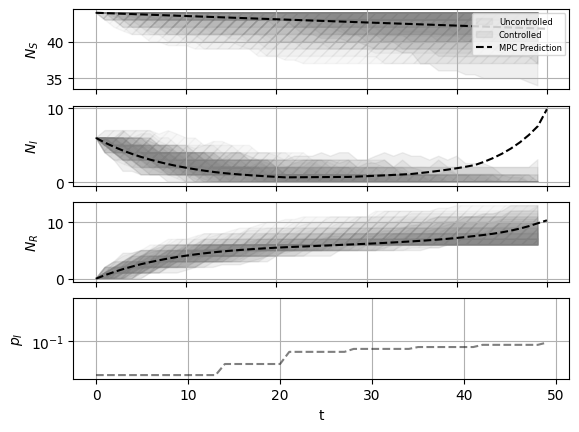

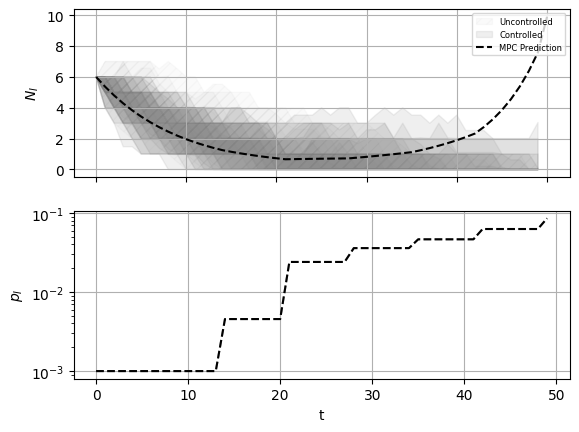

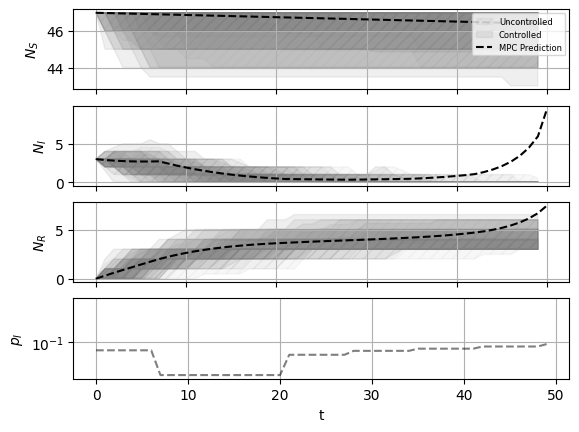

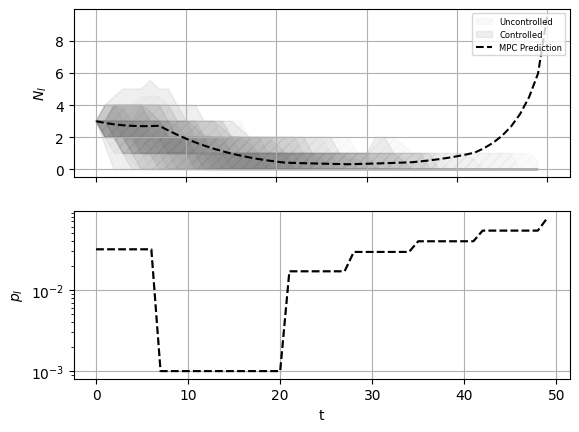

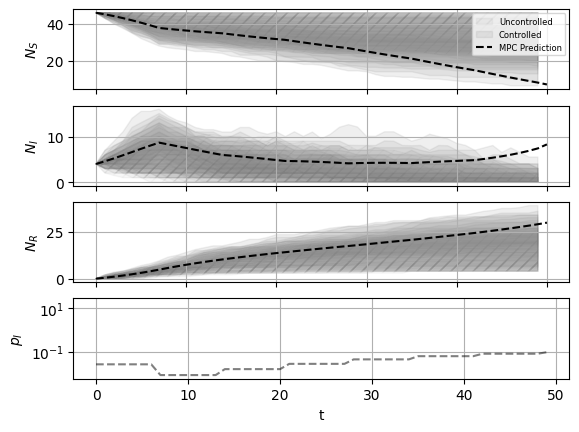

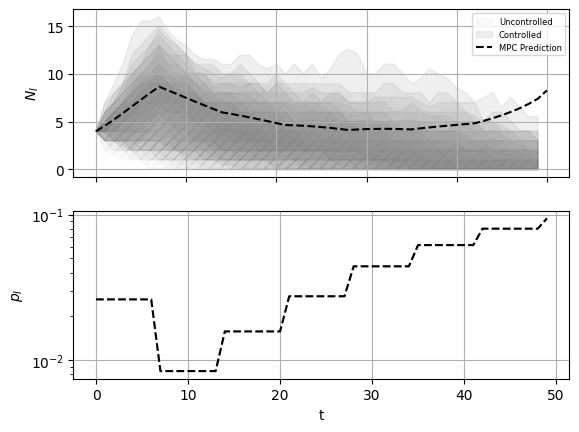

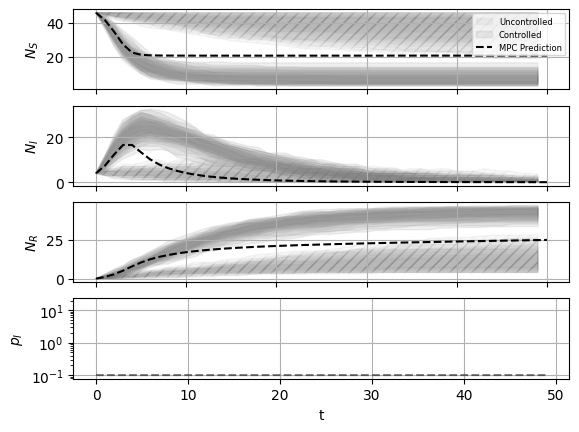

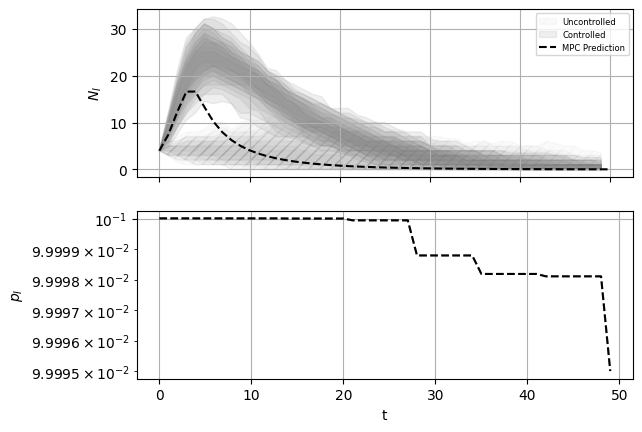

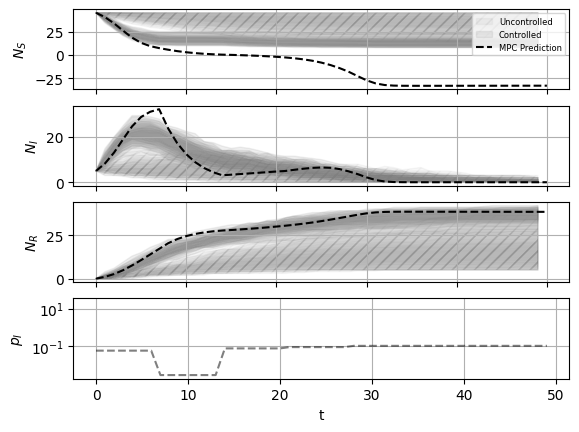

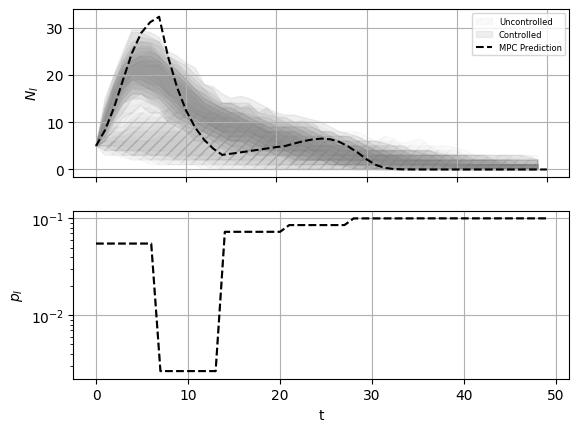

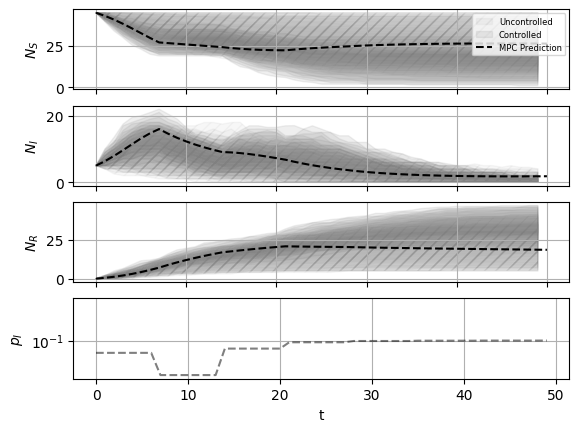

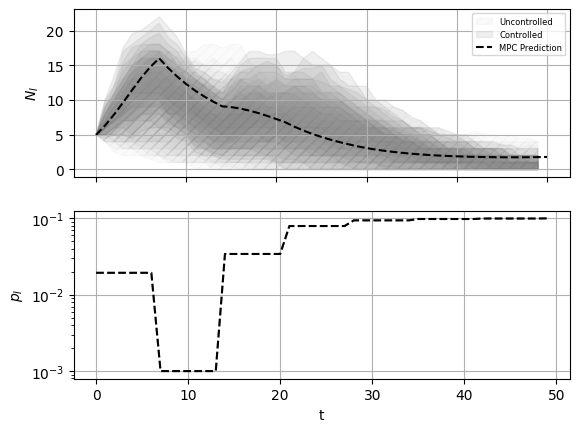

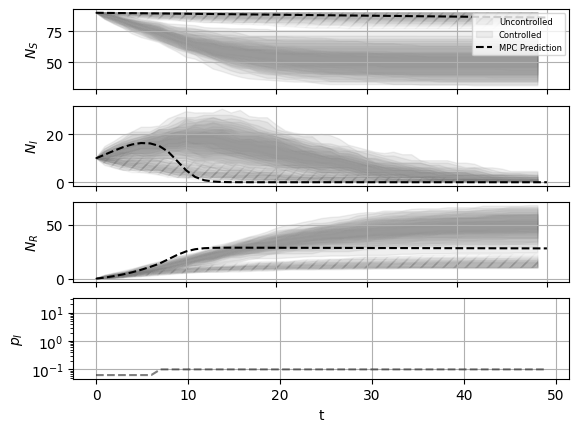

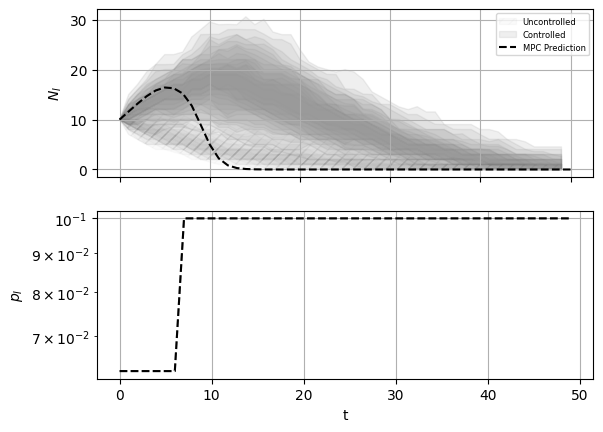

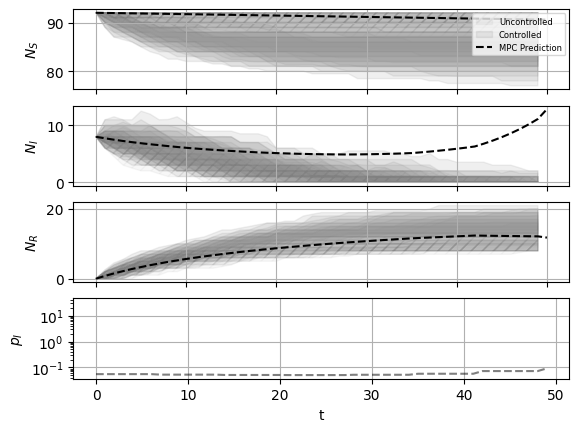

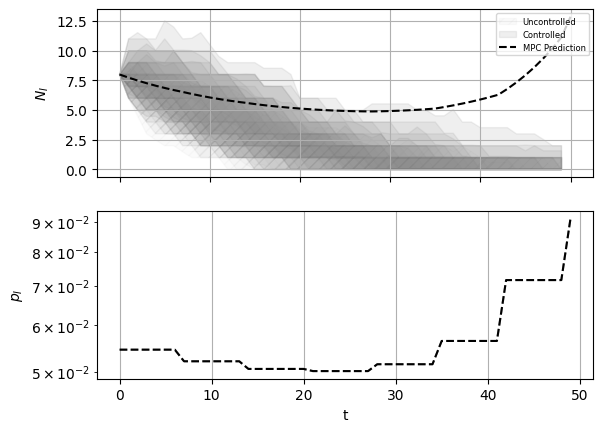

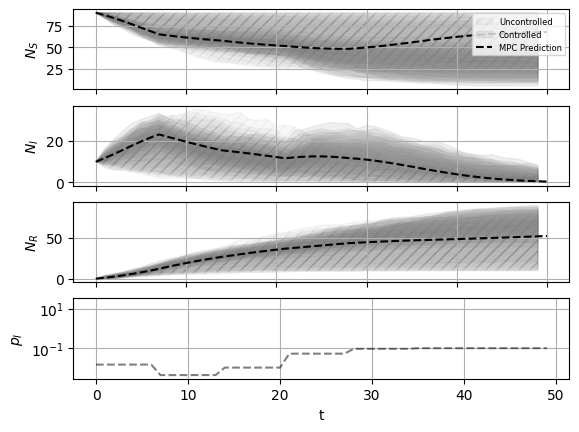

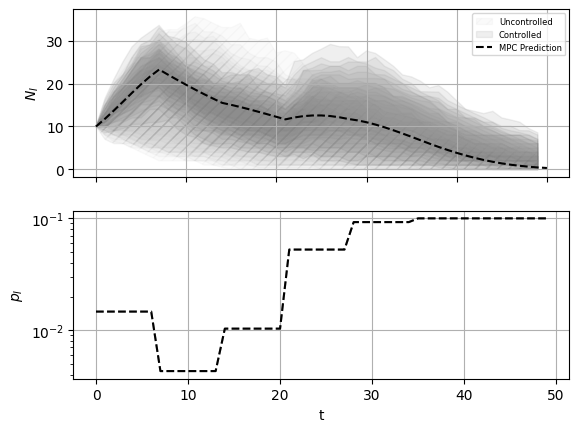

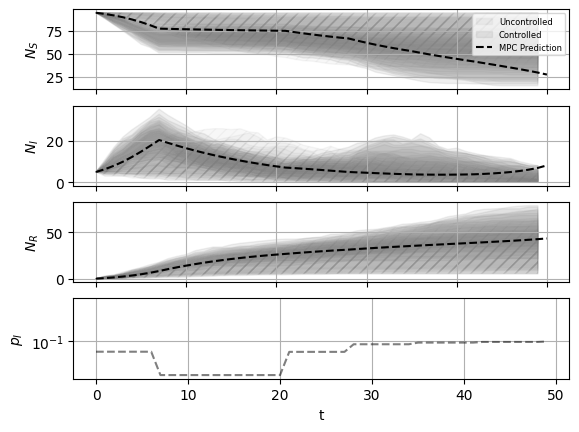

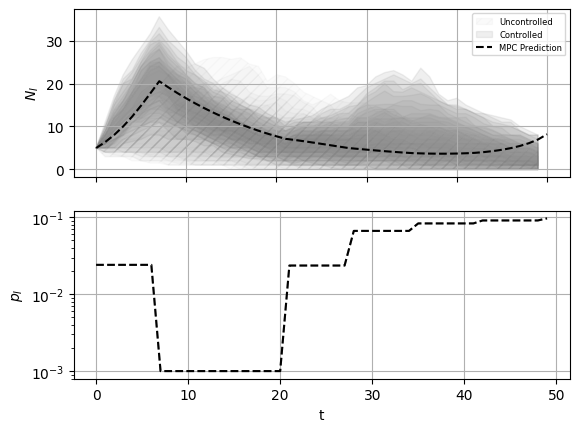

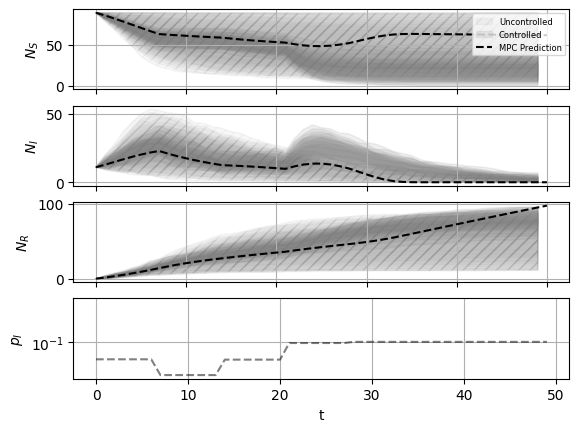

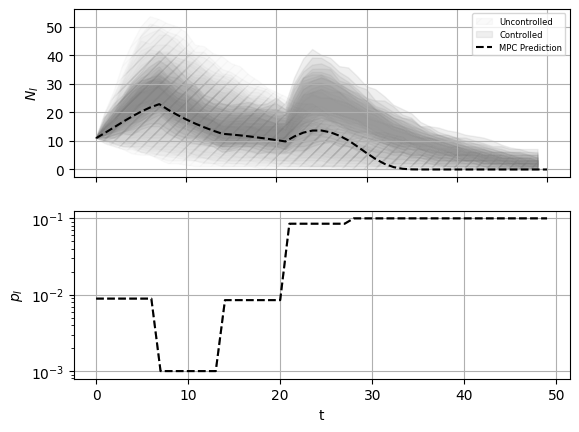

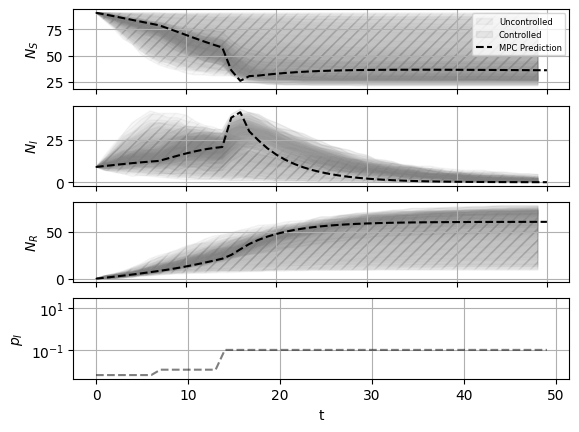

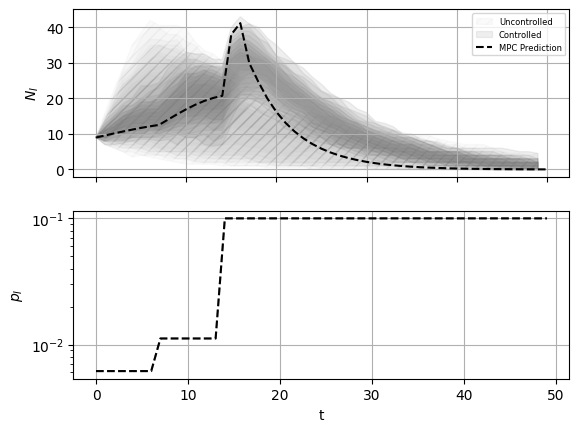

In [12]:
N_pops = [50,100]
p_ERs = [0.1, 0.5, 1.]
for N_pop in N_pops:
    for p_ER in p_ERs:
        solve_plot(N_pop, p_ER, er_regressor, er_model, file_prefix='er_')
        solve_plot(N_pop, p_ER, qr_regressor, qr_model, file_prefix='qr_')
        